In [1]:
from __future__ import absolute_import, division, print_function

# Algorithm selection

I will now explore a number of regression algorithms. Their performance when compared to each other may give a first indication on what the most promising algorithms for the dataset are. I can then focus on these to furtehr optimize the hyperparameters.

For now, I include the following algorithms:

* linear regression (<a href="http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares">Sklearn</a>)
* linear regression with L2 regularization (<a href="http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression">Sklearn</a>)
* polynomial regression (<a href="http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions">Sklearn</a>)
* random forest regression (<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor">Sklearn</a>)
* gradient boosted tree regression (<a href="http://scikit-learn.org/stable/modules/ensemble.html#regression">Sklearn</a>)
* nearest neighbor regression (<a href="http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression">Sklearn</a>)
* support vector regression (<a href="http://scikit-learn.org/stable/modules/svm.html#regression">Sklearn</a>)

All algorithm are first run using their default values.

## Imports

In [2]:
import os
import pickle
import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

## Data

In [3]:
cwd = os.getcwd()
df_2013 = pd.read_pickle(os.path.join(cwd,'data','df_2013_features.df'))
df_2014 = pd.read_pickle(os.path.join(cwd,'data','df_2014_features.df'))

In [4]:
# Combine data from both years
df_all = pd.concat([df_2013,df_2014])

In [5]:
print('2013 {}'.format(df_2013.shape))
print('2014 {}'.format(df_2014.shape))
print('Combined {}'.format(df_all.shape))


2013 (955, 12)
2014 (982, 12)
Combined (1937, 12)


## Train-Test split

In [13]:
# train_test_split splits randomly, i.e., shuffled. See docs:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
y = df_all['yield']
X = df_all.drop('yield',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature scaling

The dataset contains numerical features which are on very different scales. Set up a scaler to bring all features to zero mean and unity standard deviation. Later we need to apply the scaler also to the test set.

In [19]:
from sklearn import preprocessing
columns_to_scale = df_all.columns.tolist()
columns_to_scale = [x for x in columns_to_scale if x != 'yield']
print(columns_to_scale)

std_scaler = preprocessing.StandardScaler().fit(X_train[columns_to_scale])
X_train[columns_to_scale] = std_scaler.transform(X_train[columns_to_scale])




['longitude', 'latitude', 'elevation', 'LOD', 'total_precipitation', 'minMAT30', 'maxMAT30', 'ratioMNDVI30', 'mean_wind_speed', 'mean_temperature_diff', 'std_temperature_diff']


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
# Don't forget to apply the scaler also to the test set.
X_test[columns_to_scale] = std_scaler.transform(X_test[columns_to_scale])



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Algorithms

In [21]:
# Use cros validation. Set 'k' and the scoring function. If scoring function is not set, 
# cross_val_score will use the default scoring for the respective estimator. To make sure 
# I compare all estimators on the same scale, I set the scoring function explicitly.
from sklearn.model_selection import cross_val_score
cv_k = 5
cv_scoring = 'neg_mean_squared_error'
# cv_scoring = 'r2'

The order of the locations in the data is still such that they are grouped by county. For a reliable training and testing scenario, the data will have to be shuffled.

In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=cv_k, shuffle=True)

In [23]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [24]:
# Linear regression
now = time.time()
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -95.19 (+/- 13.29)
Exec. time:  0.04 s


/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [25]:
# Linear regression with L2 regularization
now = time.time()
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -96.43 (+/- 19.71)
Exec. time:  0.03 s


In [26]:
# Polynomial regression
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -63.56 (+/- 32.93)
Exec. time:  0.07 s


In [27]:
# Polynomial regression with regularization
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -54.44 (+/- 5.94)
Exec. time:  0.03 s


In [41]:
# Random forest regression
now = time.time()
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -27.6584 (+/- 3.5176)
Exec. time:  1.66 s


In [29]:
# Gradient boosted regression
now = time.time()
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                max_depth=0.3, random_state=0, loss='ls')
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -173.9931 (+/- 19.0146)
Exec. time:  0.13 s


In [30]:
# Nearest neighbor regression
now = time.time()
n_neighbors = 5
weight = 'uniform' # 'distance'
est = neighbors.KNeighborsRegressor(n_neighbors, weights=weight, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -31.97 (+/- 4.58)
Exec. time:  0.73 s


In [32]:
# Support vector regression - RBF kernel
now = time.time()
est = SVR(kernel='rbf', C=1, gamma=0.1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -70.19 (+/- 17.06)
Exec. time:  0.45 s


In [33]:
# Support vector regression - linear kernel
now = time.time()
est = SVR(kernel='linear', C=1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -101.89 (+/- 13.38)
Exec. time:  0.38 s


In [34]:
# Support vector regression - polynomial kernel
# This takes much longer than the previous two SVR methods.
# Reduce size of dataset even further
# idx = np.random.choice(len(X_train), size=1000, replace=False)
# X_train_part = X_train.iloc[idx]
# y_train_part = y_train.iloc[idx]
now = time.time()
est = SVR(kernel='poly', C=1e3, degree=2)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -82.65 (+/- 28.71)
Exec. time:  8.51 s


In [35]:
# KernelRidge
# Crashes due to memory issues when using the full data (-> 140k rows)
#
# idx = np.random.choice(len(X_train), size=10000, replace=False)
# X_train_part = X_train.iloc[idx]
# y_train_part = y_train.iloc[idx]
#
from sklearn.kernel_ridge import KernelRidge
now = time.time()
est = KernelRidge(kernel='rbf', gamma=0.1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: -53.06 (+/- 10.40)
Exec. time:  0.43 s


Out of the bag, the random forest regressor performed the best, followed nearest neighbor regression, KernelRidge, and L2 linear regression with polynomial features.

## Tuning the gradient boosted tree regressor

The GBT rgressor - the recent favorite among many machine-learning competitions - performed rather poorly compared to other algorithms. Obviously, I did not perform any parameter tuning, but rather used the default values. Now let's see if we can increase the performance by tuning some of the main parameters:

In [37]:
# Gradient boosted regression - with hyperparameter tuning
from sklearn.model_selection import GridSearchCV
now = time.time()
# Set the parameters by cross-validation

tuned_parameters = [{'n_estimators': [100,500,1000], 
                     'max_depth': [3,5,7,10], 
                    'learning_rate': [0.1,0.5,1.0,]}]


est_base = GradientBoostingRegressor(random_state=0, loss='ls')

est = GridSearchCV(est_base, tuned_parameters, cv=kf, scoring=cv_scoring, n_jobs=-1)

est.fit(X_train, y_train)

means = est.cv_results_['mean_test_score']
stds = est.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, est.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
    
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))




-35.596 (+/-9.069) for {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
-25.602 (+/-7.545) for {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3}
-24.522 (+/-7.505) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 3}
-25.727 (+/-5.214) for {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}
-21.944 (+/-4.704) for {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5}
-21.842 (+/-4.678) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 5}
-22.590 (+/-8.575) for {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 7}
-21.805 (+/-8.611) for {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 7}
-21.796 (+/-8.613) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 7}
-26.701 (+/-16.846) for {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10}
-26.659 (+/-16.843) for {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 10}
-26.659 (+/-16.843) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth'

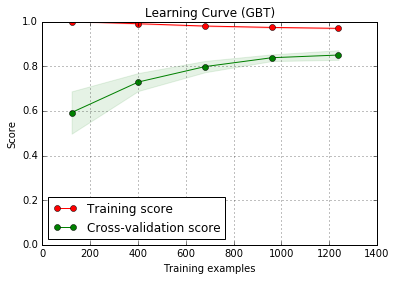

In [42]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = X_train, y_train


title = "Learning Curve (GBT)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                max_depth=5, random_state=0, loss='ls')


plot_learning_curve(est, title, X, y, ylim=(0, 1.0), cv=kf, n_jobs=-1)


plt.show()

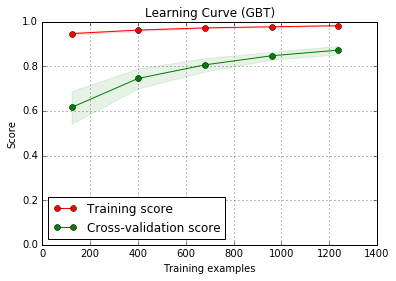

In [43]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = X_train, y_train


title = "Learning Curve (GBT)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

est = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
#                                 max_depth=5, random_state=0, loss='ls')


plot_learning_curve(est, title, X, y, ylim=(0, 1.0), cv=kf, n_jobs=-1)


plt.show()